## Neural Network Clasification


### Make classification data and get ready

In [1]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [2]:
n_sample = 1000
X, y = make_circles(n_sample, noise=0.03, random_state=1234)
len(X), len(y)

(1000, 1000)

In [3]:
X.shape, y.shape

((1000, 2), (1000,))

### Make a DataFrame of circle data

In [4]:
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,-0.527766,0.612121,1
1,0.753251,-0.105005,1
2,-0.345128,0.957593,0
3,-0.755676,-0.142257,1
4,0.717383,-0.693979,0
5,-0.119208,-0.987418,0
6,-0.523598,0.578420,1
7,0.601038,0.505682,1
8,0.008148,0.753410,1
9,0.261648,0.949329,0


### Visualizing the data

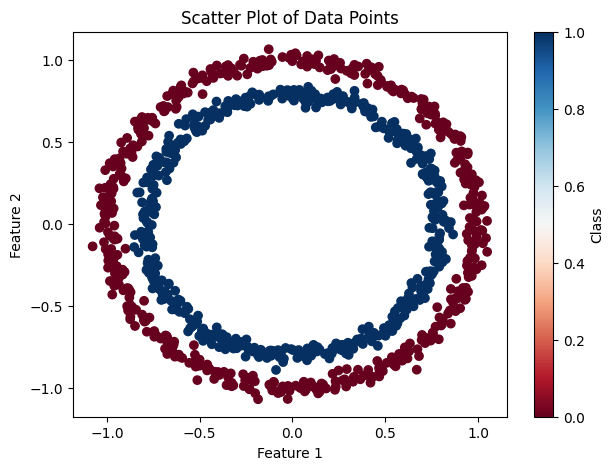

In [5]:
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu')
plt.colorbar(label='Class')
plt.title('Scatter Plot of Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Turn data in to Tensors

In [6]:
import torch
torch.__version__

'2.2.1+cu121'

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[-0.5278,  0.6121],
         [ 0.7533, -0.1050],
         [-0.3451,  0.9576],
         [-0.7557, -0.1423],
         [ 0.7174, -0.6940]]),
 tensor([1., 1., 0., 1., 0.]))

In [8]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1234)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## Model Building

In [10]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
class CircleMode1V0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=32, bias=True)
        self.layer_2 = nn.Linear(in_features=32, out_features=1, bias=True)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [12]:
model_0 = CircleMode1V0().to(device)
model_0

CircleMode1V0(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=1, bias=True)
)

### Using the nn.Sequential model

In [13]:
model_1 = nn.Sequential(
        nn.Linear(in_features=2, out_features=16, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=32, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=1, bias=True)
)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In [14]:
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5616, -0.2108],
                      [-0.0704,  0.6068],
                      [ 0.5533, -0.7020],
                      [ 0.1320, -0.0665],
                      [ 0.0125,  0.4769],
                      [ 0.3964,  0.0696],
                      [ 0.0838,  0.4277],
                      [-0.1982, -0.2744],
                      [-0.1332,  0.2833],
                      [ 0.1194,  0.4841],
                      [ 0.3714, -0.4847],
                      [ 0.4022, -0.6717],
                      [ 0.5727, -0.6699],
                      [ 0.5860, -0.1737],
                      [ 0.3849,  0.4444],
                      [-0.3416, -0.6961]])),
             ('0.bias',
              tensor([ 0.4299, -0.3173, -0.4198,  0.5221,  0.3310,  0.2445,  0.3315,  0.0109,
                      -0.6568, -0.4032,  0.2745,  0.3469, -0.1052,  0.5082, -0.2193, -0.0901])),
             ('2.weight',
              tensor([[ 0.0275, -0.1449,  0.0598, -0.0320,

## Setup Loss function and Optimizer

In [15]:
loss_func = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.01
)

In [16]:
def accuracy_func(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## Train the Model

In [17]:
model_1.to(device)

epochs = 500

for epoch in range(epochs):
    # Move data to the correct device (this part is correct in your code)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Compute loss and accuracy
    loss = loss_func(y_logits, y_train)
    acc = accuracy_func(y_true=y_train, y_pred=y_pred)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_func(test_logits, y_test)
        test_acc = accuracy_func(y_test, test_pred)

    # Logging
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69117, Acc: 60.50% | Test loss: 0.68785, Test acc: 51.00%
Epoch: 20 | Loss: 0.56669, Acc: 75.38% | Test loss: 0.56134, Test acc: 76.50%
Epoch: 40 | Loss: 0.21078, Acc: 99.75% | Test loss: 0.20486, Test acc: 99.00%
Epoch: 60 | Loss: 0.03595, Acc: 100.00% | Test loss: 0.04235, Test acc: 99.50%
Epoch: 80 | Loss: 0.01247, Acc: 100.00% | Test loss: 0.02057, Test acc: 100.00%
Epoch: 100 | Loss: 0.00715, Acc: 100.00% | Test loss: 0.01478, Test acc: 100.00%
Epoch: 120 | Loss: 0.00482, Acc: 100.00% | Test loss: 0.01212, Test acc: 100.00%
Epoch: 140 | Loss: 0.00347, Acc: 100.00% | Test loss: 0.01062, Test acc: 100.00%
Epoch: 160 | Loss: 0.00258, Acc: 100.00% | Test loss: 0.00954, Test acc: 100.00%
Epoch: 180 | Loss: 0.00199, Acc: 100.00% | Test loss: 0.00878, Test acc: 100.00%
Epoch: 200 | Loss: 0.00157, Acc: 100.00% | Test loss: 0.00818, Test acc: 100.00%
Epoch: 220 | Loss: 0.00128, Acc: 100.00% | Test loss: 0.00771, Test acc: 100.00%
Epoch: 240 | Loss: 0.00106, Acc: 100.00% 

## Visualize the train and test results

In [18]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py is already exists!")
else:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py is already exists!


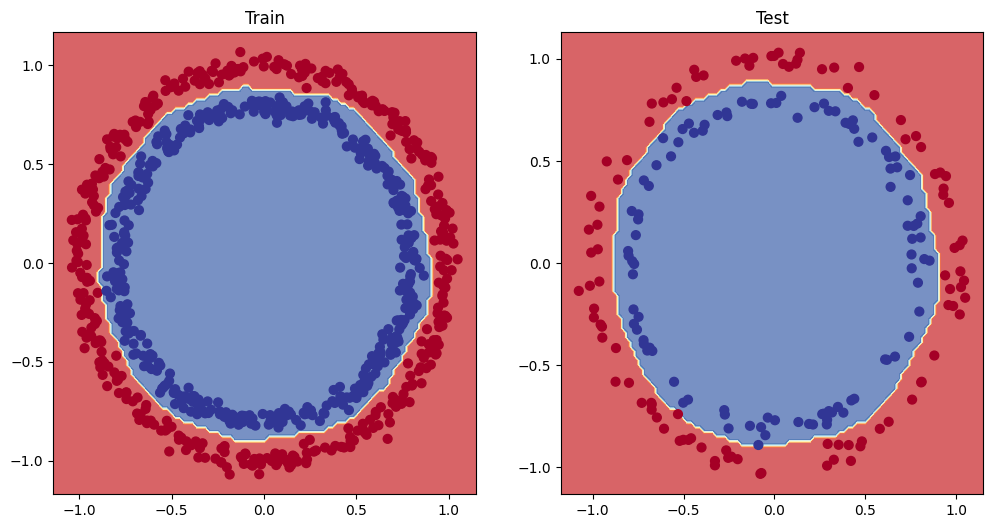

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

---

# Multiclass Classification


In [20]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [21]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 123

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)
y_blob.shape

(1000,)

In [22]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [23]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

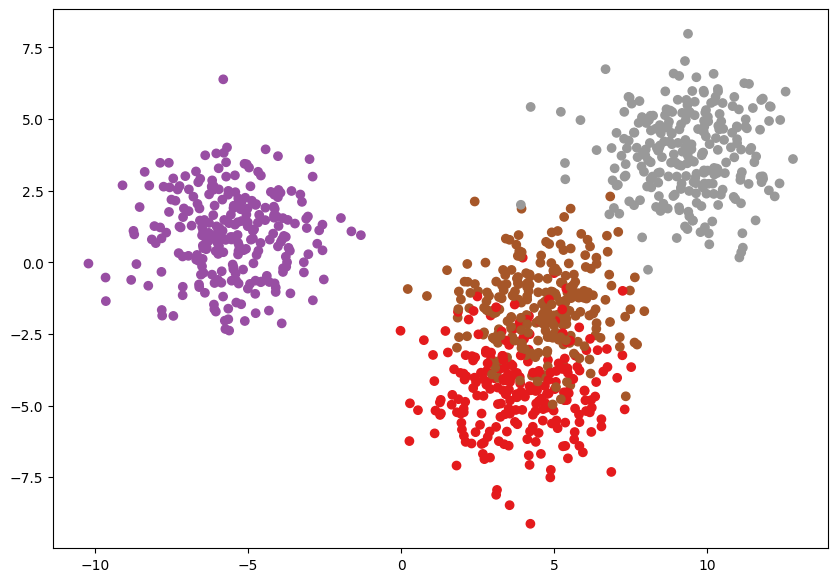

In [24]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap="Set1")
plt.show()

## Building a Multiclass Classifier

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [26]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=16):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [27]:
model_multi = BlobModel(input_features=2,
                        output_features=4,
                        hidden_units=32).to(device)
model_multi

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [28]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_multi.parameters(),
                             lr=0.01)

In [29]:
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_multi.train()

    y_logits = model_multi(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_func(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_multi.eval()
    with torch.inference_mode():
      test_logits = model_multi(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_func(y_true=y_blob_test,
                             y_pred=test_pred)

    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.55310, Acc: 26.50% | Test loss: 1.24868, Test acc: 42.00%
Epoch: 10 | Loss: 0.28621, Acc: 89.25% | Test loss: 0.31397, Test acc: 89.00%
Epoch: 20 | Loss: 0.23174, Acc: 89.25% | Test loss: 0.30262, Test acc: 88.00%
Epoch: 30 | Loss: 0.21797, Acc: 89.75% | Test loss: 0.29667, Test acc: 88.00%
Epoch: 40 | Loss: 0.20529, Acc: 90.88% | Test loss: 0.26616, Test acc: 89.00%
Epoch: 50 | Loss: 0.19689, Acc: 91.00% | Test loss: 0.25828, Test acc: 90.00%
Epoch: 60 | Loss: 0.18915, Acc: 91.25% | Test loss: 0.24458, Test acc: 90.50%
Epoch: 70 | Loss: 0.18323, Acc: 91.38% | Test loss: 0.23701, Test acc: 91.00%
Epoch: 80 | Loss: 0.17980, Acc: 91.38% | Test loss: 0.23190, Test acc: 92.50%
Epoch: 90 | Loss: 0.17792, Acc: 91.75% | Test loss: 0.22985, Test acc: 92.50%


In [30]:
model_multi.eval()
with torch.inference_mode():
    y_logits = model_multi(X_blob_test)

In [31]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_func(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([0, 1, 2, 2, 3, 3, 0, 3, 0, 1])
Labels: tensor([0, 1, 0, 2, 3, 2, 0, 3, 0, 1])
Test accuracy: 92.5%


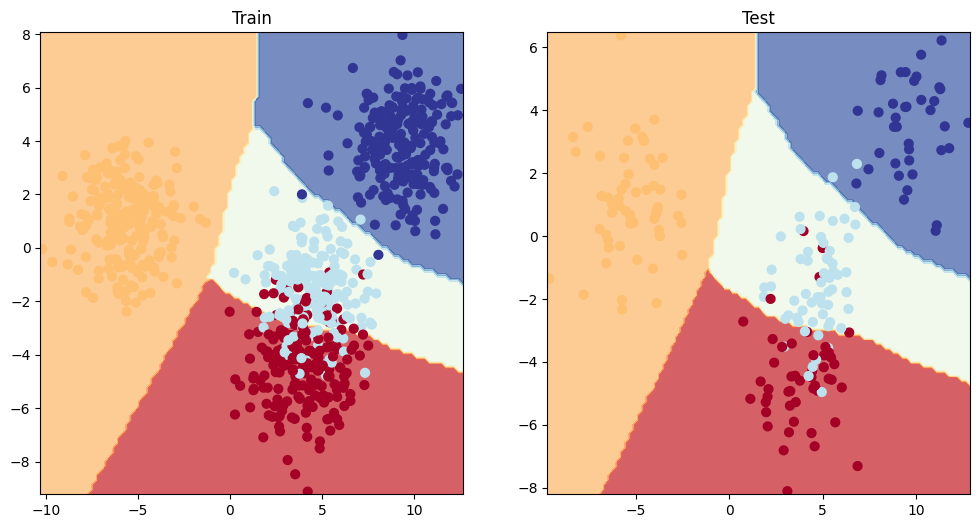

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_multi, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_multi, X_blob_test, y_blob_test)

In [33]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

tensor(0.9250)